In [3]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [5]:
from typing import TypedDict, List, Dict

class AgentState(TypedDict):
    goal: str
    tasks: List[str]
    current_task: str
    completed: List[str]
    results: Dict[str, str]

In [6]:
def planner_node(state: AgentState) -> AgentState:
    prompt = f"""
You are a planning agent.
Break the following goal into clear, ordered, actionable tasks.

Goal:
{state['goal']}

Return only a numbered list.
"""

    response = llm.invoke(prompt)
    lines = response.content.split("\n")

    tasks = []
    for line in lines:
        line = line.strip()
        if line and line[0].isdigit():
            tasks.append(line)

    return {
        "goal": state["goal"],
        "tasks": tasks,
        "current_task": "",
        "completed": [],
        "results": {}
    }

In [7]:
def executor_node(state: AgentState) -> AgentState:
    index = len(state["completed"])
    current_task = state["tasks"][index]

    prompt = f"""
You are an execution agent.
Complete the following task clearly and concisely.

Task:
{current_task}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "current_task": current_task,
        "results": {
            **state["results"],
            current_task: response.content
        }
    }


In [8]:
def validator_node(state: AgentState) -> AgentState:
    task = state["current_task"]
    result = state["results"][task]

    prompt = f"""
You are a validation agent.

Task:
{task}

Result:
{result}

Is the result satisfactory and complete?
Answer only YES or NO.
"""

    response = llm.invoke(prompt)

    if "YES" in response.content.upper():
        return {
            **state,
            "completed": state["completed"] + [task]
        }

    return state


In [9]:
def should_continue(state: AgentState) -> str:
    if len(state["completed"]) < len(state["tasks"]):
        return "execute"
    return "end"

In [10]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("planner", planner_node)
graph.add_node("execute", executor_node)
graph.add_node("validate", validator_node)

graph.set_entry_point("planner")

graph.add_edge("planner", "execute")
graph.add_edge("execute", "validate")

graph.add_conditional_edges(
    "validate",
    should_continue,
    {
        "execute": "execute",
        "end": END
    }
)

app = graph.compile()

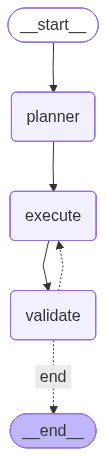

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
goal = "I want to learn agentic ai"

initial_state: AgentState = {
    "goal": goal,
    "tasks": [],
    "current_task": "",
    "completed": [],
    "results": {}
}

final_state = app.invoke(initial_state)


In [13]:
print("Completed Tasks\n")

for task, result in final_state["results"].items():
    print(task)
    print(result)
    print("-" * 60)

Completed Tasks

1. Research the concept of agentic AI to understand its definition and significance.
**Agentic AI: Definition and Significance**

**Definition:**
Agentic AI refers to artificial intelligence systems that possess a degree of autonomy and decision-making capabilities, allowing them to act independently in pursuit of specific goals. These systems can analyze their environment, make choices based on that analysis, and execute actions without direct human intervention. The term "agentic" emphasizes the AI's role as an agent capable of taking initiative and influencing outcomes.

**Significance:**
1. **Autonomy in Decision-Making:** Agentic AI can operate in complex environments where human oversight is impractical, enabling faster and more efficient decision-making processes.

2. **Enhanced Problem-Solving:** These systems can tackle intricate problems by evaluating vast amounts of data and generating solutions that may not be immediately apparent to human operators.

3. **